In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm
from IPython.display import clear_output
from itertools import product
import cv2 as cv

from utils import patient, dataset_INCan
from models import DBT_extractor

/home/ricardo/miniconda3/envs/cedm-deep/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.7.1+cu110 True


In [3]:
class budget_creator():
    def __init__(self):
        self._init_extractor()
        self.dataset = dataset_INCan()
        self._init_others()
        self.coord_list = list(self.points_in_circle(radius=2))
        self.rad_list = ['V', 'L', 'M']
        self.time_list = [1,2]
        self.vmin = -168
        self.vmax = 232

    def __repr__(self) -> str:
        return f'Budget creator using:\n{self.extractor}\n{self.dataset}\nAround points:{self.coord_list}'

    def _init_extractor(self):
        # define extractor
        config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
        model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
        min_score = 0.001 # minimum score to keep prediction
        self.extractor = DBT_extractor(config_file, model_file, min_score)

    def _init_others(self):
        # dirs
        self.saving_dir = repo_path / 'data/budget/feature_substractions'
        self.saving_dir.mkdir(exist_ok=True, parents=True)
        self.im_saving_dir = repo_path / 'data/budget/im_substractions'
        self.im_saving_dir.mkdir(exist_ok=True, parents=True)
        # read csv with bbox breast coordinates
        bbox_path = repo_path / 'data/deep/breast_bbox/coords.csv'
        self.breast_bbox = pd.read_csv(bbox_path, index_col=0)
    
    def points_in_circle(self, radius):
        """iterable that yields all possible combinations of x and y coordinates within cicle of fixed radius

        Args:
            radius (int): radius of circle

        Yields:
            set: set with combinations
        """
        for x, y in product(range(int(radius) + 1), repeat=2):
            if x**2 + y**2 <= radius**2:
                yield from set(((x, y), (x, -y), (-x, y), (-x, -y),))

    def transformation(self, im: sitk.Image, parameterMap_path:str, format='np', show=False):
        """apply transformation to an image

        Args:
            im (sitk.Image): image to be transformed
            parameterMap (sitk.ParameterMap): transformation settings
            format (str, optional): output format. Defaults to 'np'.

        Returns:
            np.array or sitk.Image: transformed image
        """
        transformixImageFilter = sitk.TransformixImageFilter()
        parameterMap = sitk.ReadParameterFile(str(parameterMap_path))
        transformixImageFilter.SetTransformParameterMap(parameterMap)
        transformixImageFilter.SetMovingImage(im)
        transformixImageFilter.Execute()
        im_result = transformixImageFilter.GetResultImage()
        clear_output(wait=show)
        if format=='sitk':
            return im_result
        elif format=='np':
            im_array = sitk.GetArrayFromImage(im_result)
            im_array = im_array.astype(np.uint16)
            return im_array
        else:
            raise ValueError('format must be "sitk" or "np"')
    
    def translate_image(self, im:np.array, x_trans:int, y_trans:int):
        """translate image given x and y translation

        Args:
            im (np.array): image to be translated
            x_trans (int): x translation
            y_trans (int): y translation

        Returns:
            np.array: translated image
        """
        #get height and width
        height, width = im.shape[:2]
        #create translation matrix
        T = np.float32([[1, 0, x_trans], [0, 1, y_trans]])
        #translate
        img_translation = cv.warpAffine(im, T, (width, height))

        return img_translation
    
    def prepare_array(self, array:np.array):
        """map array to the range 0-255, and clip values below min_val and above max_val

        Args:
            array (np.array): image array

        Returns:
            np.array: image array clipped and mapped to 0-255
        """
        # send to min value all piel below that value
        array[array<self.vmin] = self.vmin
        # same for max value
        array[array>self.vmax] = self.vmax
        # map im_array to 256 pixels
        array = (array - np.min(array)) / (np.max(array) - np.min(array))
        array = (array * 255).astype(np.uint8)
        return array


In [7]:
budgeter = budget_creator()

for (x_trans, y_trans) in tqdm(budgeter.coord_list):
        for rad in budgeter.rad_list:
            for time in budgeter.time_list:
                  for pat_num in tqdm(budgeter.dataset.pat_num):
                        #define fixed and moving
                        pat = patient(pat_num=pat_num)
                        fixedImage = pat.get_im(sequence='CMC', format = 'sitk')
                        movingImage = pat.get_im(sequence='SMC', format='sitk')
                        # transform
                        im_transformed = budgeter.transformation(movingImage, repo_path / f'data/registration/transform_{pat_num}.txt', format='sitk')
                        # substract
                        fixed_array = sitk.GetArrayFromImage(fixedImage)
                        im_transformed_array = sitk.GetArrayFromImage(im_transformed)
                        im_moved_array = budgeter.translate_image(im_transformed_array, x_trans, y_trans)
                        im_substraction = -(fixed_array.astype(np.int32) - im_moved_array.astype(np.int32)).astype(np.int16)
                        if pat.laterality == 'R':
                              # except for the first patient, which is already flipped
                              if pat.pat_num != '2':
                                    im_substraction = np.fliplr(im_substraction)
                        im_substraction = budgeter.prepare_array(im_substraction)
                        # CLIP
                        bbox = budgeter.breast_bbox.loc[int(pat_num)].values
                        im_substraction = im_substraction[bbox[1]:bbox[3],bbox[0]:bbox[2]]
                        # save image as png
                        sitk_substraction = sitk.GetImageFromArray(im_substraction)
                        sitk.WriteImage(sitk_substraction, str(budgeter.im_saving_dir / f'Pat_{pat_num}_SET_x{x_trans}_y{y_trans}.png'))

                        # read pngs
                        image_path = budgeter.im_saving_dir / f'Pat_{pat_num}_SET_x{x_trans}_y{y_trans}.png'
                        mask_path = repo_path / 'data/deep/G_masks' / f'Pat_{pat_num}_mask_{rad}_{time}.png'
                        image_rgb = cv.imread(str(image_path))
                        mask_array = cv.imread(str(mask_path), cv.IMREAD_GRAYSCALE)

                        # create bbox
                        bbox_lesion, _ = budgeter.extractor.get_normal_BBox(mask_array)
                        # extract
                        features = budgeter.extractor.extract_1024(image_rgb, bbox_lesion)
                        df = budgeter.extractor.features_to_csv(features, pat_num)
                        budgeter.extractor.update_main_df(df)
                  budgeter.extractor.save_main_df(rad, time, save_path=budgeter.saving_dir / f'x{x_trans}_y{y_trans}_{rad}_{time}.csv')

ELASTIX version: 5.000
Command line options from ElastixBase:
-out      ./
-threads  unspecified, so all available threads are used
-def      unspecified, so no input points transformed
-jac      unspecified, so no det(dT/dx) computed
-jacmat   unspecified, so no dT/dx computed

Reading input image ...
  Reading input image took 0.000001 s
Calling all ReadFromFile()'s ...
  Calling all ReadFromFile()'s took 0.000041 s
Transforming points ...
  The command-line option "-def" is not used, so no points are transformed
  Transforming points done, it took 0.00s
Compute determinant of spatial Jacobian ...
  The command-line option "-jac" is not used, so no det(dT/dx) computed.
  Computing determinant of spatial Jacobian done, it took 0.00s
Compute spatial Jacobian (full matrix) ...
  The command-line option "-jacmat" is not used, so no dT/dx computed.
  Computing spatial Jacobian done, it took 0.00s
Resampling image and writing to disk ...


 62%|██████▏   | 8/13 [17:27<10:54, 130.99s/it]

  Resampling took 0.22s


SystemError: <built-in function TransformixImageFilter_Execute> returned a result with an error set

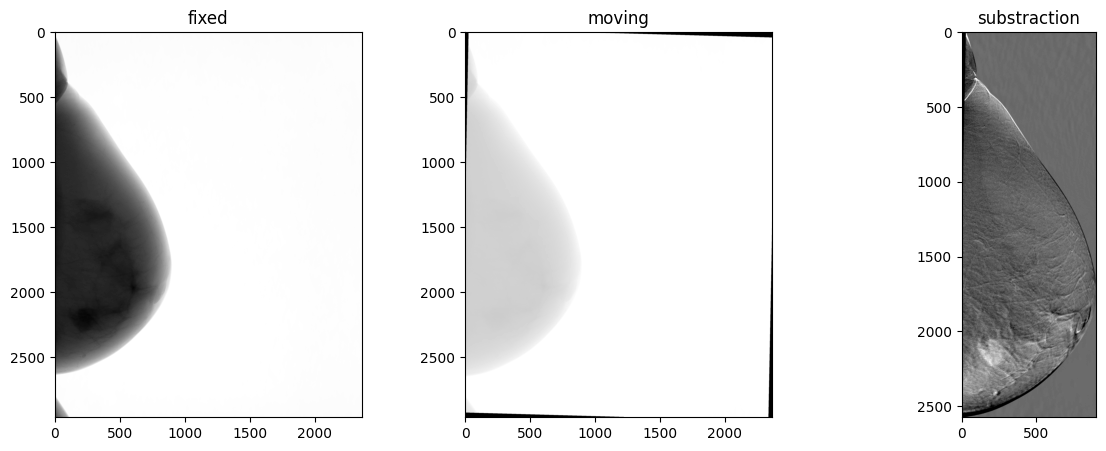

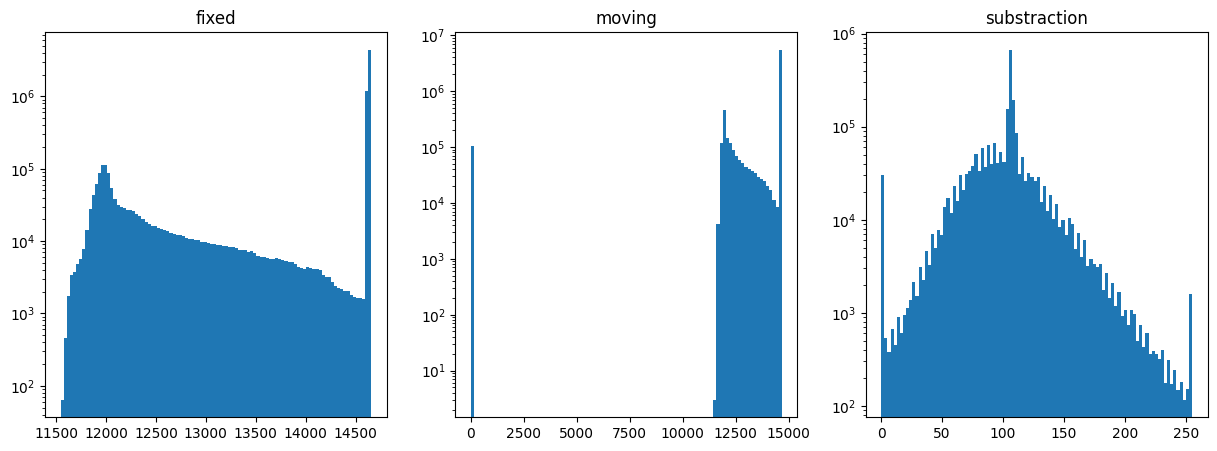

In [91]:
# plot fixed, moving and substraction
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(fixed_array, cmap='gray')
ax[0].set_title('fixed')
ax[1].imshow(im_moved_array, cmap='gray')
ax[1].set_title('moving')
ax[2].imshow(im_substraction, cmap='gray')
ax[2].set_title('substraction')
plt.show()

# show also histograms
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(fixed_array.flatten(), bins=100, log=True)
ax[0].set_title('fixed')
ax[1].hist(im_moved_array.flatten(), bins=100, log=True)
ax[1].set_title('moving')
ax[2].hist(im_substraction.flatten(), bins=100, log=True)
ax[2].set_title('substraction')
plt.show()
